# spam-filter-gridsearch

This series of notebooks are used to develop a full NLP pipeline (tokenization, lemmatization, vectorization, cross-validation/testing) for creating a spam filter. The model will be trained/tested using a dataset available on Kaggle: https://www.kaggle.com/uciml/sms-spam-collection-dataset.

This notebook goes through the hyperparameter-tuning process for the machine learning models. For exploratory data analysis and data cleaning, see the *spam-filter* notebook; for vectorization and ML model training/testing, see the *spam-filter-ml* notebook.

### Preamble and repeated cells from previous notebook (vectorization and splitting data into training/testing)

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as scores, precision_score, recall_score, make_scorer, precision_recall_curve, roc_curve, auc

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
df = pd.read_csv('spam_updated.csv')
pd.set_option('display.max_colwidth', 100)
df.head()

,label,text_len,text_punct,text_cap,raw_text
0,ham,92,0.098,0.033,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,24,0.250,0.083,Ok lar... Joking wif u oni...
2,spam,128,0.047,0.078,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,39,0.154,0.051,U dun say so early hor... U c already then say...
4,ham,49,0.041,0.041,"Nah I don't think he goes to usf, he lives around here though"


In [8]:
# Define clean_text function to be used as the analyser in the tfidf vectorizer
def clean_text(text):
    wnl = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = ''.join([char.lower() for char in text if char not in string.punctuation])
    tokenized_list = re.split('\W+', text)
    text = [wnl.lemmatize(word) for word in tokenized_list if word not in stopwords and word != '']
    return text

In [9]:
# Split data into features (X) and labels (y), then split into training/testing sets
X = df[['raw_text', 'text_len', 'text_punct', 'text_cap']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
# Initialise the vectorizer, fit using raw text in training data
tfidf = TfidfVectorizer(analyzer=clean_text)
tfidf_fit = tfidf.fit(X_train['raw_text'])

In [11]:
# Use vectorizer to transform both training and testing set; returns a sparse matrix, need to use .toarray() method to read
tfidf_train = pd.DataFrame(tfidf_fit.transform(X_train['raw_text']).toarray())
tfidf_test = pd.DataFrame(tfidf_fit.transform(X_test['raw_text']).toarray())

# Rename vectorized columns with names of tokens
tfidf_train.columns = tfidf_fit.get_feature_names()
tfidf_test.columns = tfidf_fit.get_feature_names()

# Concatenate vectorized text and other features into training and testing dataframes
X_train_vect = pd.concat([X_train[['text_len', 'text_punct', 'text_cap']].reset_index(drop=True), tfidf_train], axis=1)
X_test_vect = pd.concat([X_test[['text_len', 'text_punct', 'text_cap']].reset_index(drop=True), tfidf_test], axis=1)

In [12]:
# Train using X_train_vect, y_train; make predictions on X_test_vect, y_test

RFC = RandomForestClassifier(n_jobs=-1) # Run jobs in parallel; use default hyperparameters for now

fit_start = time.time()
RFC_model = RFC.fit(X_train_vect, y_train) 
fit_end = time.time()
fit_time = fit_end - fit_start

pred_start = time.time()
RFC_y_pred = RFC_model.predict(X_test_vect)
pred_end = time.time()
pred_time = pred_end - pred_start

# Calculate precision/recall/f1 scores by comparing predictions and test data; use 'spam' as the positive label
precision, recall, f1, support = scores(y_test, RFC_y_pred, pos_label='spam', average='binary')
print('Fit time: {}s, Pred time: {}s | Precision: {}, Recall: {}, F1: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round(f1, 3)))

Fit time: 0.759s, Pred time: 0.241s | Precision: 1.0, Recall: 0.841, F1: 0.914


In [13]:
# Repeat process using gradient boosted trees

GBT = GradientBoostingClassifier() # Run jobs in parallel; use default hyperparameters for now

fit_start = time.time()
GBT_model = GBT.fit(X_train_vect, y_train) 
fit_end = time.time()
fit_time = fit_end - fit_start

pred_start = time.time()
GBT_y_pred = GBT_model.predict(X_test_vect)
pred_end = time.time()
pred_time = pred_end - pred_start

# Calculate precision/recall/f1 scores by comparing predictions and test data; use 'spam' as the positive label
precision, recall, f1, support = scores(y_test, GBT_y_pred, pos_label='spam', average='binary')
print('Fit time: {}s, Pred time: {}s | Precision: {}, Recall: {}, F1: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round(f1, 3)))

Fit time: 36.019s, Pred time: 0.139s | Precision: 0.992, Recall: 0.89, F1: 0.938


# Tuning hyperparameters using GridSearchCV

Note: these grid-searches were performed without specifiying the scoring method. Since this is a spam-filter, it would be ideal to minimise the number of false positives (i.e. real emails/ham misclassified as spam), as this has negative consequences in a real-life business situation. Therefore, the precision score of the model is arguably the most important and should be maximised. The recall score takes into account the number of false negatives (i.e. spam misclassified as real emails/ham); ideally, this should also be maximised, but is less of a priority than the precision score for this problem. Proper grid-searches where the scoring method is explicity defined is done in the next section below.

### Random Forest Classifier

In [9]:
# RFC hyperparameter tuning

RFC = RandomForestClassifier(n_jobs=-1)
RFC_params = {'n_estimators': [10, 50, 100, 200, 300, 500],
             'max_depth': [20, 40, 60, 80, 100, None]}

RFC_GS = GridSearchCV(RFC, RFC_params, cv=5, n_jobs=-1) # Perform 5-fold cross-validation, conduct jobs in parallel
RFC_GS_fit = RFC_GS.fit(X_train_vect, y_train)

In [50]:
RFC_results = pd.DataFrame(RFC_GS_fit.cv_results_)
RFC_results.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
19,2.694666,0.125765,0.378199,0.248654,80,50,"{'max_depth': 80, 'n_estimators': 50}",0.974215,0.969731,0.976431,...,0.974871,0.003287,1,1.0,0.999439,0.99972,0.999159,0.999159,0.999495,0.000327
34,22.479615,2.077200,3.987035,0.389050,None,300,"{'max_depth': None, 'n_estimators': 300}",0.975336,0.971973,0.978676,...,0.974422,0.003202,2,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
32,4.266202,0.585318,0.923006,0.047902,None,100,"{'max_depth': None, 'n_estimators': 100}",0.974215,0.969731,0.974186,...,0.974198,0.002548,3,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
29,36.838290,1.897558,2.574735,1.242099,100,500,"{'max_depth': 100, 'n_estimators': 500}",0.975336,0.969731,0.977553,...,0.974198,0.003816,3,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
26,4.095117,0.603194,0.875162,0.092967,100,100,"{'max_depth': 100, 'n_estimators': 100}",0.975336,0.966368,0.975309,...,0.973749,0.003717,5,1.0,1.000000,1.00000,0.999720,1.000000,0.999944,0.000112


### Gradient Boosted Trees

In [22]:
# GBT hyperparameter tuning

GBT = GradientBoostingClassifier()
GBT_params = {'n_estimators': [100, 300, 500], # GBT works better with many estimators that have are more shallow compared to RFC
             'max_depth': [5, 10, None],
             'learning_rate': [0.01, 0.1, 1]}

GBT_GS = GridSearchCV(GBT, GBT_params, cv=5, n_jobs=-1) # Perform 5-fold cross-validation, conduct jobs in parallel
GBT_GS_fit = GBT_GS.fit(X_train_vect, y_train)

In [49]:
GBT_results = pd.DataFrame(GBT_GS_fit.cv_results_)
GBT_results.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,471.033025,3.002779,0.217539,0.026598,0.1,5,500,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}",0.979821,0.966368,...,0.976890,0.005329,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
14,801.674959,54.059547,0.238761,0.015251,0.1,10,500,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}",0.980942,0.964126,...,0.976442,0.006761,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
13,582.187606,3.391342,0.218129,0.019305,0.1,10,300,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}",0.979821,0.966368,...,0.975544,0.005178,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
10,285.606467,1.023179,0.181514,0.002442,0.1,5,300,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}",0.977578,0.965247,...,0.974647,0.004938,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
12,216.391659,4.214193,0.174543,0.008357,0.1,10,100,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}",0.978700,0.960762,...,0.974422,0.007514,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0


### Multilayer Perceptron

In [27]:
# MLP hyperparameter tuning

MLP = MLPClassifier()
MLP_params = {'hidden_layer_sizes': [10, 50, 100, 200], # GBT works better with many estimators that have are more shallow compared to RFC
             'activation': ['relu', 'tanh', 'logistic'],
             'learning_rate': ['constant', 'invscaling', 'adaptive']}

MLP_GS = GridSearchCV(MLP, MLP_params, cv=5, n_jobs=-1) # Perform 5-fold cross-validation, conduct jobs in parallel
MLP_GS_fit = MLP_GS.fit(X_train_vect, y_train)

In [48]:
MLP_results = pd.DataFrame(MLP_GS_fit.cv_results_)
MLP_results.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
21,332.182882,30.403524,0.220609,0.008088,tanh,200,constant,"{'activation': 'tanh', 'hidden_layer_sizes': 200, 'learning_rate': 'constant'}",0.978700,0.980942,...,0.984294,0.003812,1,1.000000,1.0,1.00000,1.0,1.0,1.000000,0.000000
34,678.082324,59.744037,0.217719,0.015229,logistic,200,invscaling,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling'}",0.978700,0.979821,...,0.983621,0.003852,2,1.000000,1.0,1.00000,1.0,1.0,1.000000,0.000000
15,221.636807,10.963911,0.129759,0.003409,tanh,50,constant,"{'activation': 'tanh', 'hidden_layer_sizes': 50, 'learning_rate': 'constant'}",0.979821,0.980942,...,0.983397,0.003118,3,1.000000,1.0,1.00000,1.0,1.0,1.000000,0.000000
33,596.520698,72.511875,0.222519,0.006347,logistic,200,constant,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate': 'constant'}",0.979821,0.980942,...,0.983397,0.002776,3,1.000000,1.0,1.00000,1.0,1.0,1.000000,0.000000
29,347.985155,24.730214,0.136041,0.005520,logistic,50,adaptive,"{'activation': 'logistic', 'hidden_layer_sizes': 50, 'learning_rate': 'adaptive'}",0.980942,0.979821,...,0.983397,0.003118,3,0.999719,1.0,0.99972,1.0,1.0,0.999888,0.000137


### Support Vector Classifier

In [30]:
# Support Vector Classifier hyperparameter tuning

SVM = SVC()
SVM_params = {'C': [0.01, 0.1, 1, 10, 100]}

SVM_GS = GridSearchCV(SVM, SVM_params, cv=5, n_jobs=-1) # Perform 5-fold cross-validation, conduct jobs in parallel
SVM_GS_fit = SVM_GS.fit(X_train_vect, y_train)

In [31]:
SVM_results = pd.DataFrame(SVM_GS_fit.cv_results_)
SVM_results.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,75.127635,15.896474,16.831728,4.836345,100,{'C': 100},0.885650,0.892377,0.912458,0.912458,...,0.900606,0.010702,1,0.906592,0.903506,0.900168,0.901851,0.902412,0.902906,0.002135
3,81.057478,5.496299,17.681929,1.715388,10,{'C': 10},0.872197,0.877803,0.901235,0.895623,...,0.883105,0.012963,2,0.890603,0.884712,0.880538,0.881660,0.888671,0.885237,0.003892
2,73.213032,1.366580,16.510090,0.174032,1,{'C': 1},0.866592,0.876682,0.863075,0.863075,...,0.866951,0.005051,3,0.887518,0.880505,0.862591,0.862591,0.885025,0.875646,0.010894
0,66.559258,1.107112,16.058674,0.056827,0.01,{'C': 0.01},0.862108,0.862108,0.863075,0.863075,...,0.862688,0.000474,4,0.862833,0.862833,0.862591,0.862591,0.862591,0.862688,0.000119
1,70.511421,1.903480,16.282591,0.241290,0.1,{'C': 0.1},0.862108,0.862108,0.863075,0.863075,...,0.862688,0.000474,4,0.862833,0.862833,0.862591,0.862591,0.862591,0.862688,0.000119


### Logistic Regression

In [46]:
# Logistic Regression hyperparameter tuning

LogReg = LogisticRegression()
LogReg_params = {'C': [0.01, 0.1, 1, 10, 100]}

LogReg_GS = GridSearchCV(LogReg, LogReg_params, cv=5, n_jobs=-1) # Perform 5-fold cross-validation, conduct jobs in parallel
LogReg_GS_fit = LogReg_GS.fit(X_train_vect, y_train)

In [47]:
LogReg_results = pd.DataFrame(LogReg_GS_fit.cv_results_)
LogReg_results.sort_values('mean_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,1.160531,0.064991,0.066622,0.008425,100,{'C': 100},0.976457,0.973094,0.980920,0.984287,...,0.978461,0.003838,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,1.031799,0.052681,0.066923,0.004351,10,{'C': 10},0.976457,0.970852,0.976431,0.979798,...,0.976217,0.002950,2,0.999158,0.998878,0.998317,0.998878,0.998598,0.998766,0.000286
2,0.877978,0.026604,0.056938,0.004665,1,{'C': 1},0.952915,0.945067,0.955107,0.960718,...,0.954005,0.005145,3,0.971108,0.970266,0.970836,0.969994,0.970275,0.970496,0.000411
1,0.938820,0.067158,0.070013,0.026883,0.1,{'C': 0.1},0.881166,0.877803,0.884400,0.878788,...,0.879515,0.003059,4,0.885273,0.884432,0.885586,0.879697,0.886708,0.884339,0.002433
0,0.851371,0.054368,0.057052,0.002634,0.01,{'C': 0.01},0.857623,0.858744,0.852974,0.859708,...,0.856630,0.002635,5,0.856942,0.856942,0.857824,0.858104,0.856983,0.857359,0.000502


# Tuning hyperparameters using GridSearchCV, with precision_score

Tuning hyperparameters for the random forest classifier, gradient boosted trees, and multilayer perceptron. GridSearchCV method used to find the optimal hyperparameters to optimise the precision score for each model. The best models are ranked according to their mean precision and mean recall scores.

In [19]:
# Define scoring method to be used in GridSearch CV
precision_scorer = make_scorer(precision_score, pos_label='spam')
recall_scorer = make_scorer(recall_score, pos_label='spam')

### Random Forest Classifier

In [25]:
RFC = RandomForestClassifier(n_jobs=-1)
RFC_params = {'n_estimators': [10, 50, 100, 200, 300, 500],
             'max_depth': [80, 100, None]}

# Grid-search + 5-fold cross-validation results in 6 * 3 * 5 = 90 models being generated

RFC_GS = GridSearchCV(RFC, RFC_params, cv=5, n_jobs=-1, scoring={'precision_scorer': precision_scorer, 'recall_scorer': recall_scorer}, refit='precision_scorer') # Perform 5-fold cross-validation, conduct jobs in parallel
RFC_GS_fit = RFC_GS.fit(X_train_vect, y_train)

In [49]:
RFC_results = pd.DataFrame(RFC_GS_fit.cv_results_)
cols = ['mean_fit_time', 'mean_score_time', 'params', 'mean_test_precision_scorer', 'mean_test_recall_scorer', 'rank_test_precision_scorer', 'rank_test_recall_scorer']
RFC_results[cols].sort_values(['mean_test_precision_scorer', 'mean_test_recall_scorer'], ascending=[False, False])[:5]

,mean_fit_time,mean_score_time,params,mean_test_precision_scorer,mean_test_recall_scorer,rank_test_precision_scorer,rank_test_recall_scorer
5,34.720276,4.393556,"{'max_depth': 80, 'n_estimators': 500}",1.0,0.812287,1,1
8,4.369905,2.474578,"{'max_depth': 100, 'n_estimators': 100}",1.0,0.810633,1,2
10,19.683171,6.218031,"{'max_depth': 100, 'n_estimators': 300}",1.0,0.810633,1,2
4,21.091032,6.592858,"{'max_depth': 80, 'n_estimators': 300}",1.0,0.805647,1,5
2,5.645418,2.992563,"{'max_depth': 80, 'n_estimators': 100}",1.0,0.802328,1,6


The random forest classifiers take the shortest time to train, and the best RFC models give the best precision scores overall (100%). On the other hand, the prediction times are relatively longer, generally requiring more than 1 second to make a spam/ham prediction on a piece of text. The recall scores also suffer; the best model is the top scorer for both precision and recall, but only has a recall score of 81.2%. This can be improved by further tuning of the hyperparameters, but for the purposes of a spam filter (minimise false positives and maximise precision score), these models should suffice.

### Gradient Boosted Trees

In [26]:
# GBT hyperparameter tuning

GBT = GradientBoostingClassifier()
GBT_params = {'n_estimators': [400, 450, 500, 550, 600], # GBT works better with many estimators that have are more shallow compared to RFC
             'max_depth': [5, 6, 7, 8, 9, 10]}

# Grid-search + 5-fold cross-validation results in 5 * 6 * 5 = 150 models being generated

GBT_GS = GridSearchCV(GBT, GBT_params, cv=5, n_jobs=-1, scoring={'precision_scorer': precision_scorer, 'recall_scorer': recall_scorer}, refit='precision_scorer') # Perform 5-fold cross-validation, conduct jobs in parallel
GBT_GS_fit = GBT_GS.fit(X_train_vect, y_train)

In [36]:
GBT_results = pd.DataFrame(GBT_GS_fit.cv_results_)
cols = ['mean_fit_time', 'mean_score_time', 'params', 'mean_test_precision_scorer', 'mean_test_recall_scorer', 'rank_test_precision_scorer', 'rank_test_recall_scorer']
GBT_results[cols].sort_values(['mean_test_precision_scorer', 'mean_test_recall_scorer'], ascending=[False, False])[:5]

,mean_fit_time,mean_score_time,params,mean_test_precision_scorer,mean_test_recall_scorer,rank_test_precision_scorer,rank_test_recall_scorer
4,608.522695,0.483408,"{'max_depth': 5, 'n_estimators': 600}",0.984607,0.840548,1,30
3,539.037942,0.522940,"{'max_depth': 5, 'n_estimators': 550}",0.983009,0.845534,2,22
13,740.086748,0.466765,"{'max_depth': 7, 'n_estimators': 550}",0.982944,0.842214,3,26
14,806.249868,0.509747,"{'max_depth': 7, 'n_estimators': 600}",0.979404,0.843892,4,23
5,494.682198,0.429304,"{'max_depth': 6, 'n_estimators': 400}",0.979403,0.852186,5,6


The gradient boosted trees perform slightly worse in terms of precision (~98%), and only slightly better in terms of recall (~84%). The models that give the best precision scores also rank relatively poorly in terms of recall, ranking between 23-30th out of the 150 models generated. Due to the complexity of the algorithm and the inability to generate the estimators in parallel, the fitting time for these models are much longer at roughly 10 minutes per model. However, prediction times are much shorter, at about half a second. (Note that previous tests with a lower number of estimators used in the GBT models had shorter training times, but gave even poorer precision scores.) This suggests that gradient boosted trees are likely a poor candidate algorithm to be used for the spam detection filter.

### Multilayer Perceptron

In [27]:
# MLP hyperparameter tuning

MLP = MLPClassifier()
MLP_params = {'hidden_layer_sizes': [10, 50, 100, 200], # GBT works better with many estimators that have are more shallow compared to RFC
             'activation': ['relu', 'tanh', 'logistic'],
             'learning_rate': ['constant', 'invscaling', 'adaptive']}

# Grid-search + 5-fold cross-validation results in 4 * 3 * 3 * 5 = 180 models being generated

MLP_GS = GridSearchCV(MLP, MLP_params, cv=5, n_jobs=-1, scoring={'precision_scorer': precision_scorer, 'recall_scorer': recall_scorer}, refit='precision_scorer') # Perform 5-fold cross-validation, conduct jobs in parallel
MLP_GS_fit = MLP_GS.fit(X_train_vect, y_train)

In [38]:
MLP_results = pd.DataFrame(MLP_GS_fit.cv_results_)
cols = ['mean_fit_time', 'mean_score_time', 'params', 'mean_test_precision_scorer', 'mean_test_recall_scorer', 'rank_test_precision_scorer', 'rank_test_recall_scorer']
MLP_results[cols].sort_values(['mean_test_precision_scorer', 'mean_test_recall_scorer'], ascending=[False, False])[:5]

,mean_fit_time,mean_score_time,params,mean_test_precision_scorer,mean_test_recall_scorer,rank_test_precision_scorer,rank_test_recall_scorer
2,128.752426,0.239063,"{'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate': 'adaptive'}",0.988483,0.838835,1,34
9,311.175000,0.428066,"{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate': 'constant'}",0.983454,0.873783,2,31
11,323.391000,0.376402,"{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive'}",0.983452,0.873712,3,32
6,189.118396,0.307976,"{'activation': 'relu', 'hidden_layer_sizes': 100, 'learning_rate': 'constant'}",0.981644,0.885433,4,18
33,627.535976,0.427660,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate': 'constant'}",0.979926,0.890335,5,10


The best multilayer perceptron models have average training times (~2-6 minutes) and perform slightly better than the gradient boosted trees in terms of both precision and recall, with the best MLP model have 98.8% and 83.9% respectively. The prediction times are considerably faster than both the RFC and GBT models, with predictions being made in less than 0.5 seconds per document. The MLP models seem to perform best with the ReLU activation function, and either a constant or adaptive learning rate. However, the hidden layer structure is more variable, as the best MLP models have a single hidden layer with 10 to 200 hidden nodes. In a realistic scenario, more hidden layers/nodes may be implemented to try improve the model; for the sake of simplicity, only a single hidden layer is considered for this project. The regularization hyperparameter (alpha) has also been neglected for the same reason.

## Testing and analysing the performance of the best ML models

As stated by the no free lunch theorem, no single model is best for every problem. For this project, I will be taking the best model from each of RFC, GBT, and MLP, and testing their performance using the testing data saved from before. To visualise the performance of each model, I will plot the confusion matrices, precision-recall curves, and receiver operating characteristic (ROC) curves for each model. Performance metrics that I will consider are: precision, recall, f1, and the area under the ROC curve (AUC). These metrics and visualisation tools are appropriate for classification models; this problem is a binary classification task, as the spam detection filter classifies messages as one of two options, 'spam' or 'ham'.

Precision = $\frac{\text{true positives}}{\text{true positives + false positives}}$

Recall = $\frac{\text{true positives}}{\text{true positives + true negatives}}$

F1 = $2 \times \frac{\text{precision } \times \text{ recall}}{\text{precision + recall}}$

- Confusion matrices illustrate the number of true/false positives and true/false negatives predicted by each model
- ROC curves compares the true positive rate and false positive rate of the models at different classification probability thresholds to illustrate their diagnostic ability
    - a perfect model has a true positive rate of 1 and false positive rate of 0, and exists in the top left corner of the curve
    - a no-skill model discriminates between the classes (i.e. spam and ham) completely at random at all probability thresholds, represented by a diagonal line from (0, 0) to (1, 1)
    - however, ROC curves are typically more suitable for datasets that have a similar number of occurences for each class; in this case, there is a much higher sample of 'ham' emails compared to 'spam', and hence a precision-recall curve is more suitable
    - the area under the ROC curve (AUC) can be used to evaluate the performance of classification models; an AUC of 1 represents a perfect model
- Precision-recall curves compare the precision and recall metrics of the models at different classification probability thresholds
    - a perfect model has both precision and recall scores of 1, and exists in the top right corner of the curve
    - a no-skill model again discriminates between the classes completely at random, and is represented by a horizontal line on the precision-recall curve with a value determined by the ratio of 'spam' messages in the overall dataset
    - a precision-recall curve is more relevant to this spam detection task, as we are more interested in the number of true positives and false positives; the number of true and false negatives (i.e. respectively ham and spam being classified as ham) is less important, as discussed previously


In [50]:
RFC_best = RFC_GS_fit.best_estimator_
RFC_best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
GBT_best = GBT_GS_fit.best_estimator_
GBT_best

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [48]:
MLP_best = MLP_GS_fit.best_estimator_
MLP_best

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Random Forest Classifier | Prediction Time: 0.171, Precision: 1.0, Recall: 0.897, F1: 0.945, AUC: 0.997
Gradient Boosted Trees | Prediction Time: 0.135, Precision: 0.985, Recall: 0.91, F1: 0.946, AUC: 0.996
Multilayer Perceptron | Prediction Time: 0.052, Precision: 0.993, Recall: 0.938, F1: 0.965, AUC: 0.995


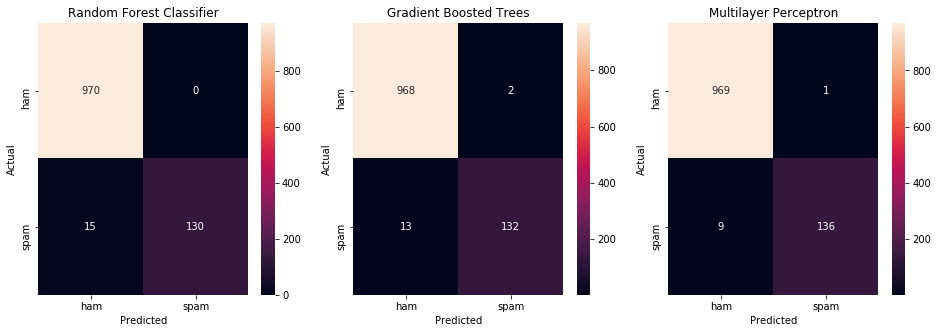

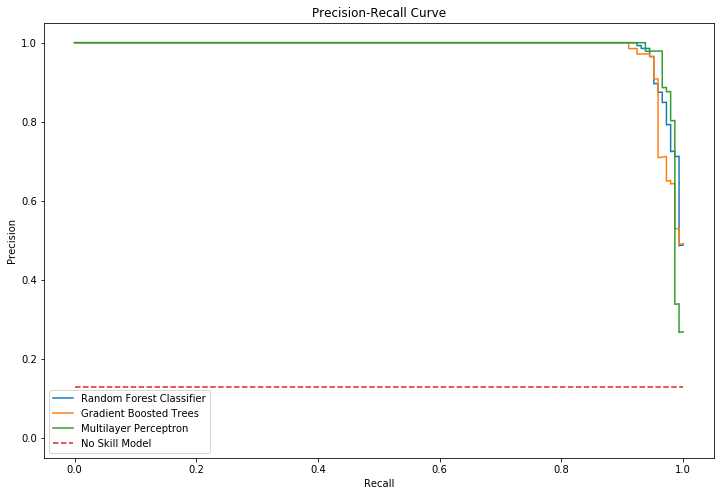

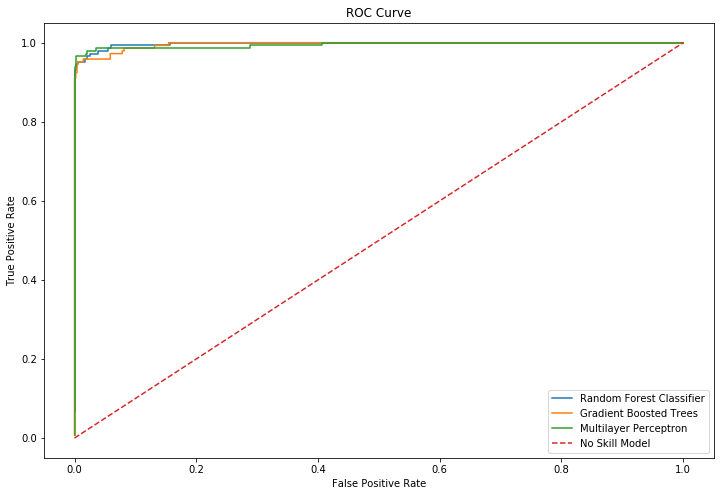

In [263]:
# Analyse the performance of the best ML models using the testing data
start = time.time()
RFC_best_pred = RFC_best.predict(X_test_vect)
end = time.time()
RFC_time = end - start
RFC_best_probs = RFC_best.predict_proba(X_test_vect)[:, 1]

start = time.time()
GBT_best_pred = GBT_best.predict(X_test_vect)
end = time.time()
GBT_time = end - start
GBT_best_probs = GBT_best.predict_proba(X_test_vect)[:, 1]

start = time.time()
MLP_best_pred = MLP_best.predict(X_test_vect)
end = time.time()
MLP_time = end - start
MLP_best_probs = MLP_best.predict_proba(X_test_vect)[:, 1]

model_preds = [RFC_best_pred, GBT_best_pred, MLP_best_pred]
model_names = ['Random Forest Classifier', 'Gradient Boosted Trees', 'Multilayer Perceptron']
model_times = [RFC_time, GBT_time, MLP_time]
model_probs = [RFC_best_probs, GBT_best_probs, MLP_best_probs]


fig = plt.figure(figsize=(16,5))
fig2, ax2 = plt.subplots(figsize=(12,8))
fig3, ax3 = plt.subplots(figsize=(12,8))

for index, (model_pred, model_name, model_time, model_prob) in enumerate(zip(model_preds, model_names, model_times, model_probs)):
    # Plot confusion matrices
    ax = fig.add_subplot(1, 3, index+1)
    ax.set_title(model_name)
    cm = pd.crosstab(y_test, model_pred, margins=False, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    
    # Plot precision-recall curves
    precisions, recalls, thresholds_pr = precision_recall_curve(y_test, model_prob, pos_label='spam')
    ax2.plot(recalls, precisions, label=model_name)
    
    # Plot ROC curves
    fpr, tpr, thresholds_roc = roc_curve(y_test, model_prob, pos_label='spam')
    ax3.plot(fpr, tpr, label=model_name)
    
    # Print scores
    precision, recall, f1, support = scores(y_test, model_pred, pos_label='spam', average='binary')
    auc_score = auc(fpr, tpr)
    print('{} | Prediction Time: {}, Precision: {}, Recall: {}, F1: {}, AUC: {}'.format(model_name, round(model_time, 3), round(precision, 3), round(recall, 3), round(f1, 3), round(auc_score, 3)))

no_skill = len(y_test[y_test=='spam']) / len(y_test) # Define the no skill threshold for precision-recall curve
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill Model')
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='lower left')
ax2.set_title('Precision-Recall Curve')

ax3.plot([0, 1], [0, 1], linestyle='--', label='No Skill Model')
ax3.set_ylim([-0.05, 1.05])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='lower right')
ax3.set_title('ROC Curve')

plt.show()

The best models all seem to perform well on the test set. The ratio of misclassifications on the overall test set is approximately 1.3% or less across the best three models. These models are near-perfect, as seen from the ROC and precision-recall curves. Their AUC scores are also 99.5% or above.

In a real-world scenario, I would choose to use the RFC model as a spam detection filter, as its near-perfect precision suggests that real emails will not be accidentally misclassifed as spam (as this scenario may present negative real-world consequences). Although the RFC model classifies approximately 1 in 10 spam emails as real emails and a worse F1 score overall, this is a worthwhile trade-off.

The RFC and GBT model objects have a *feature_importances_* attribute, which allows us to see which features (i.e. words) are most important in helping the models identify spam. The MLP model object has a similar attribute called *coefs_* which gives the weighting of the nodes, but this is much more abstract and less interpretable.

In [133]:
# Use feature_importances_ attribute of RFC object to identify which words are most important in identifying spam

RFC_features = pd.DataFrame(RFC_best.feature_importances_, columns=['RFC Feature Importance'])
RFC_features.index = X_train_vect.columns
RFC_features = RFC_features.sort_values(by=['RFC Feature Importance'], axis=0, ascending=False)
RFC_features.head(20)

,RFC Feature Importance
å,0.050888
text_len,0.039882
text_cap,0.039610
free,0.026295
txt,0.026251
call,0.021315
mobile,0.019990
claim,0.017255
service,0.017054
reply,0.013787


In [132]:
# Repeat for the GBT object; the MLP object does not have this attribute

GBT_features = pd.DataFrame(GBT_best.feature_importances_, columns=['GBT Feature Importance'])
GBT_features.index = X_train_vect.columns
GBT_features = GBT_features.sort_values(by=['GBT Feature Importance'], axis=0, ascending=False)
GBT_features.head(20)

,GBT Feature Importance
text_cap,0.024277
text_len,0.024138
call,0.016033
å,0.015133
service,0.013644
text_punct,0.013472
content,0.011557
filthy,0.011517
link,0.010972
condition,0.010650


Both the RFC and GBT models seem to be able to identify common themes/words that are more prevalent in spam messages. For example, both models identified words such as 'free', 'call', 'claim', 'service', or non-english words such as 'å' to be common in spam. It is also interesting to note that both models also confirm the idea (as discussed in the exploratory data analysis section; see the *spam-filter* notebook) that the length of the messages (text_len) and the ratio of capital letters in a message (text_cap) are good indicators of spam.

## Conclusion

In summary, I have developed a basic NLP pipeline for a spam detection filter. From this exercise, I have developed the following skills:
- Perform exploratory data analysis on an unknown dataset to understand the dataset and identify features of interest
- Data cleaning (in the context of NLP): tokenization, lemmatization, and removing punctuation/stopwords
- Vectorization of text to make it suitable for machine learning; using a fit vectorizer to transform the training and testing data
- Training and selecting suitable models for further investigation
- Tuning of hyperparameters of the machine learning models to optimise their performance for the given problem (i.e. target high precision to reduce false positive rate)
- Analysing the performance of the trained models by selecting and interpreting relevant performance metrics

## Next Steps

Below are different areas that could be further explored to improve the quality and performance of the spam detection filter:
- Conduct a more extensive analysis on the dataset to identify possible features that may help improve the model performance (percentage of numeric characters in text? percentage of words not in the English alphabet? etc.)
- Consider stopwords: what if certain stopwords actually appear more often in spam compared to regular texts? (however this may have a large effect on the vectorizer, i.e. there may be an overly high weighting on specific stopwords that may actually reduce the model accuracy)
- Try using different lemmatizers (spaCy, TextBlob, etc.) on the text to see if there are significant differences in results
- Implement a model that also takes into account the position of words in the text, and possibly word semantics; arguably, the current approach used is naive as it only takes into account the occurence of certain words in a text and in the overall dataset, and neglects how the word is positioned in relation to the rest of the text and the context in which the word is used
- Perform a wider and finer gridsearch for each model, and consider a larger number of hyperparamters in the gridsearch process; however, an argument can be made that this may potentially lead to overfitting and will simply require too much computational power and time